<div id="container" style="position:relative;">
<div style="float:left"><h1> Feature Engineering </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

The most important part of any model, whether it's a machine learning one or a statistical one, is the data.

We have seen many data sets, but a key part of a data scientist's job is to determine which parts are relevant to our desired outcome. When we run models, we want the most simple model possible with the most predictive power. If we could distill the cause of more sales down to a change in one or two variables like price and rain, we have a lot more predictive power and leverage than if it turns out to be a function of several thousand variables.

That said, sometimes the best way to explain data is the thousand variable model. The key is confirming that this is the case.

Choosing and engineering which features to include in a model is a lot like making an argument for a debate or essay. There are a lot of things of varying relevance that could be included, but the key is choosing the correct ones, synthesizing different arguments into one, and modeling them correctly.

Oftentimes, a successful model is not determined by the exact method chosen to model the outcome, but by the data and features used to create it. The first part of a successful model is usually choosing, adding, and constructing new features.

### Constructed Features

As we've progressed through the course, we've seen several data sets which we've taken as given. In practice, we might receive a data set from a client or data source that has only the most proximate data to a model, or where what the model might be is not always as clear.

For example, BrainStation Retail has provided an aggregated set of their transaction data, on which they want to be able to make predictions about total revenue across their different worldwide markets:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the retail dataset
retail_df = pd.read_csv("C:/Users/Surface/Downloads/BrainStation_Retail_Daily.csv")

# Convert datetimes
retail_df['order_date'] = pd.to_datetime(retail_df['order_date'])
retail_df['ship_date'] = pd.to_datetime(retail_df['ship_date'])

# Show
retail_df.head()

,order_date,ship_date,ship_mode,Market,Category,subcategory,order_priority,sales,quantity,profit,shipping_cost
0,2011-01-01,2011-01-05,Second Class,EMEA,Office Supplies,Storage,High,66.12,4,29.64,8.17
1,2011-01-01,2011-01-05,Second Class,EU,Office Supplies,Paper,High,44.87,3,-26.06,4.82
2,2011-01-01,2011-01-06,Standard Class,Africa,Office Supplies,Storage,Medium,408.30,2,106.14,35.46
3,2011-01-01,2011-01-08,Standard Class,APAC,Furniture,Furnishings,Medium,113.67,5,37.77,4.70
4,2011-01-01,2011-01-08,Standard Class,APAC,Office Supplies,Paper,Medium,55.24,2,15.34,1.80


If we wish to predict sales going forward, a model based on this data might be something as simple as a regression of `Sales ~ Quantity|Subcategory` _i.e._ Sales as a response of total sold per subcategory.

However, we might immediately realize that we know which markets we sold these products of a given subcategory at, so we can determine location.

Once we have location and date, we could include something like aggregate weather from an outside source. While it might not influence all items, you can imagine some product lines would be heavily influenced by weather; for example, if BrainStation retail sells patio furniture, we would expect this to be highly correlated with temperature and exhibit seasonal patterns. We can put together a script to scrape the most relevant weather data from an online provider, or pay for a database which contains this.

We know the price of shipping cost by category, will a decrease in one category lead to a greater increase than another? What about a decrease in the price of one type of office supply vs. another?

As we continue on, we can rapidly increase our feature set in our models.

---

#### Exercise 1

Imagine you have been presented the data set above from BrainStation retail. Using only a pen and paper, think about what additional features might you add.

Think of at least 5.

---

### Feature Selection

As we begin to add features to our data, we begin making our models more complex. We saw in the statistics unit that we can add random features to our data and increase our predictive power. We need to choose among the features we have been given and have created. Additionally, we have to make sure that only the best ones are chosen.

We want to remove values which do not add anything to our model. One of the easiest ways to do this is to remove items which have a low variance. If we have variance of 0 inside a feature, then this feature provides no predictive information. Similarly if our variance is very low, we might only have one or two items with any difference, and so removing the column will prevent overfitting. 

In scikit-learn, we have a `feature_selection` submodule which contains a variance thresholder:

In [3]:
# Examine only the numeric columns for 
df2 = retail_df[['sales', 'profit', 'shipping_cost']]
df2.head()

,sales,profit,shipping_cost
0,66.12,29.64,8.17
1,44.87,-26.06,4.82
2,408.30,106.14,35.46
3,113.67,37.77,4.70
4,55.24,15.34,1.80


Remember the variance is significantly impacted by the scale of the data. For a given column, the larger the numbers, generally the larger the variance would be, even if they vary around the mean relatively less than some other column with lower values. 

Lets have a look at the variances of our columns before and after scaling. 

In [4]:
df2.var()

sales            278613.608116
profit            34375.111253
shipping_cost      3847.955840
dtype: float64

So we can see that sales has by far the largest variance. Lets now scale the data. We will be using the MinMax scaler here because the MinMax scaler preserves the relative distance between the points. 

In [5]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler

my_mm = MinMaxScaler()
scaled_data = my_mm.fit_transform(df2)

df2_scaled = pd.DataFrame(data=scaled_data, columns=df2.columns)

In [6]:
df2_scaled.head()

,sales,profit,shipping_cost
0,0.002795,0.441976,0.006897
1,0.001889,0.438263,0.004069
2,0.017381,0.447076,0.029936
3,0.004822,0.442518,0.003968
4,0.002331,0.441023,0.001520


In [7]:
df2_scaled.var()

sales            0.000506
profit           0.000153
shipping_cost    0.002742
dtype: float64

We can see now that `shipping_cost` actually has the most variance! The intuition here is that the amount the shipping cost values varied around their mean is actually higher in relative terms than the sales values do. If we had not scaled the columns we likely would have ended up dropping the `shipping_cost` column. 

Now let's actually use the `VarianceThreshold` transformer from Sklearn.

In [8]:
from sklearn.feature_selection import VarianceThreshold

# Instantiate the VarianceThresholder, we need to set a threshold variance
my_vt = VarianceThreshold(threshold=0.0004)

# Fit to the data and calculate the variances per column
my_vt.fit(df2_scaled)

VarianceThreshold(threshold=0.0004)

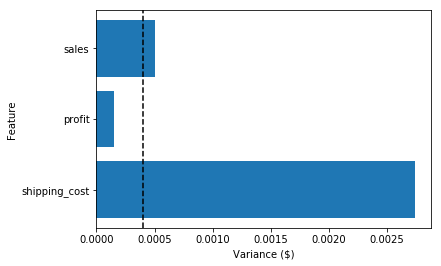

In [9]:
# Extract the variances per column
column_variances = my_vt.variances_

# Plot with the threshold
plt.figure()
plt.barh(np.flip(df2_scaled.columns), np.flip(column_variances))
plt.xlabel('Variance ($)')
plt.ylabel('Feature')
plt.axvline(0.0004, color='black', linestyle='--')
plt.show()

In [10]:
# Get the columns which are retained
my_vt.get_support()

array([ True, False,  True])

In [11]:
# Apply the variance threshold to drop columns below the given variance
pd.DataFrame(my_vt.transform(df2_scaled), columns = df2.columns[my_vt.get_support()]).head()

,sales,shipping_cost
0,0.002795,0.006897
1,0.001889,0.004069
2,0.017381,0.029936
3,0.004822,0.003968
4,0.002331,0.001520


In [12]:
# We can still apply this to the original dataframe if we wanted to continue to use the original values
pd.DataFrame(my_vt.transform(df2), columns = df2.columns[my_vt.get_support()]).head()

,sales,shipping_cost
0,66.12,8.17
1,44.87,4.82
2,408.30,35.46
3,113.67,4.70
4,55.24,1.80


Because the variance of the `profit` column is below the threshold, the `.transform()` method drops it from the data. The transformed data is nothing more than the original data with the columns with variance below the threshold value removed.

In practice, most data scientists hate to throw away data, so the variance would have to be extremely low, or 0, before a transform like this would be undertaken.

-------

### Univariate Feature Selection

We need to be careful when choosing variables for our data. We run the risk of effectively overfitting our data. We will talk about train/test split in more detail later, but be aware that this kind of processing will need to be carried out on train/test fitted data. In general, statisticians are not very fond of feature selection, they argue it is a form of p-hacking, and that we should only include and carry out the tests we planned in advance.

While there is truth in that, often times in machine learning applications we care about models which maximize our predictive ability. 

If we are okay with this, we can carry out univariate feature selection. In this case, we carry out a test on a single independent variable/feature (the uni in univariate) against our dependent variable/target. We can then choose among the features based on a threshold p-value or other test, or among a ranking. 

Here we will do a classification task, you can do a regression task by modifying the test used in order to be sensible for your data. The docs in the following link explain the methods: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest 

Say we are interested in identifying only when BrainStation retail is profitable. We can convert this regression problem of the dollars in profit into a classification by thresholding when the percentage profit (_i.e._ margin) is greater than some cut-off. In this case, we are being told by the business, we want to identify those sales above the target margin of 15%:

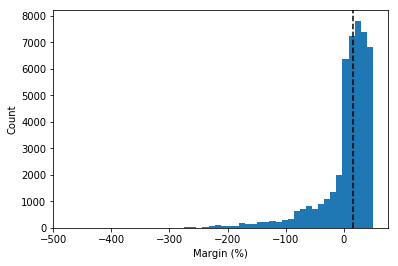

In [13]:
plt.figure()
plt.hist(retail_df['profit']/retail_df['sales']*100.0, bins=50)
plt.xlabel('Margin (%)')
plt.ylabel('Count')
plt.axvline(15, color='black', linestyle='--')
plt.show()

Now we will construct (engineer) a new feature, in this case a binary target feature, by applying this threshold:

In [2]:
retail_df['margin_gt_15'] = (retail_df['profit']/retail_df['sales'] > 0.15).astype(int)

In [5]:
retail_df.head()

,order_date,ship_date,ship_mode,Market,Category,subcategory,order_priority,sales,quantity,profit,shipping_cost,margin_gt_15
0,2011-01-01,2011-01-05,Second Class,EMEA,Office Supplies,Storage,High,66.12,4,29.64,8.17,1
1,2011-01-01,2011-01-05,Second Class,EU,Office Supplies,Paper,High,44.87,3,-26.06,4.82,0
2,2011-01-01,2011-01-06,Standard Class,Africa,Office Supplies,Storage,Medium,408.30,2,106.14,35.46,1
3,2011-01-01,2011-01-08,Standard Class,APAC,Furniture,Furnishings,Medium,113.67,5,37.77,4.70,1
4,2011-01-01,2011-01-08,Standard Class,APAC,Office Supplies,Paper,Medium,55.24,2,15.34,1.80,1


Then we could look at various contingency tables for the [chi-squared test](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2), and figure out which categorical features are most predictive. For example, by product category:

In [16]:
pd.crosstab(index=retail_df['margin_gt_15'], columns=retail_df['Category'])

Category,Furniture,Office Supplies,Technology
margin_gt_15,,,
0,5040,12267,4795
1,4010,15538,4594


We can also do this using different types of scoring functions (as detailed on the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) documentation) depending on how we want to quantify how predictive a feature is, and whether or not the problem is classification or regression. For example, for our BrainStation retail dataset, we can compare whether quantity or shipping cost is more predictive of margin, based on their [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) score:

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Pull out features and target
X = retail_df[['quantity', 'shipping_cost']]
y = retail_df['margin_gt_15']

# Instantiate KBest feature selector and fit
my_KBest = SelectKBest(f_classif, k=1).fit(X, y)

In [18]:
my_KBest.get_support()

array([ True, False])

In [19]:
my_KBest.scores_

array([9.7419504 , 4.13761886])

So here in this example, we can see that quantity is actually a better predictor than shipping cost.

---

#### Exercise 2

1. Run the KBest feature selector on the Diabetes Progression data set. Choose K = 5 initially, and make sure to choose a scoring function appropriate for a regression problem.
2. Which features were selected?
3. How does the fit of a linear regression vary on K from 1 to 5?
4. What would happen to a K best selector if some of the K features are correlated?

In [6]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

diabetes_df = pd.DataFrame(data=X, columns=diabetes.feature_names)
diabetes_df['progression'] = y
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [9]:
# Examine only the numeric columns for 
df = diabetes_df[['age', 'sex', 'progression']]
df.head()

,age,sex,progression
0,0.038076,0.050680,151.0
1,-0.001882,-0.044642,75.0
2,0.085299,0.050680,141.0
3,-0.089063,-0.044642,206.0
4,0.005383,-0.044642,135.0


In [10]:
df.var()

age               0.002268
sex               0.002268
progression    5943.331348
dtype: float64

---

### Multivariate Feature Selection

This is similar to the univariate case, but this time we run the data in combinations. This is significantly more complicated. Scikit-learn provides a recursive feature eliminator as well as ways to run trees or regressions to select a subset of parameters: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html.  

One commonly used method, which is not implemented in scikit-learn, is [stepwise regression](https://en.wikipedia.org/wiki/Stepwise_regression). In this method, we add a variable to a regression, test for model improvement, and if it is the 'best' one, add it, and check for any variables we can now remove, until we reach a point where the model can no longer be improved.

### Regularization

We previously saw lasso (L1) and ridge (L2) regression. These methods shrink the coefficients of our regression towards 0 by penalizing large betas:

$$ Cost = \sum\limits_{i=1}^{n}(y_i - \hat{y})^2 + \alpha\sum\limits_{j=1}^{p}|\beta_j|^q$$

Where the $q$=1 in lasso and $q$=2 in ridge. This is a version of multivariate feature selection, albeit a more valid one. Scikit-learn regularizes many of its models, so it is often valid to throw everything in, rather than strictly selecting like we are doing above.

---

#### Exercise 3

1. Run a ridge and lasso regression on the diabetes data. How do the coefficients of each compare?

---

### Categorical-to-Numerical conversion

Before we look at the other classification techniques, we need to learn about ways to represent categorical data as numerical data.  Most of the scikit-learn models require numerical inputs, but we have a number of ways to convert data.

### One-Hot Encoding

One method of changing categorical values into numerical values (appropriate for when there is no inherent order to the categories) is called "one-hot" encoding. This takes a single column of categorical data with k categories and transforms it into k columns of binary 0/1 data, one column for each of the unique category values that existed in the column. Each row will have a $1$ in the column corresponding to its original categorical value, and a $0$ in all the other columns.

Pandas comes with an easy, built-in method for carrying out this one-hot encoding process: `pd.get_dummies()`. It takes as input a Series (or DataFrame), and outputs a DataFrame with the categorical columns converted into sets of one-hot-encoded columns. (Any numerical columns are left unchanged.)

Scikit-learn implements this slightly differently than pandas, via the `OneHotEncoder` as we shall see shortly.

For example, with our BrainStation retail data, we can look at the categorical values in the Market column:

In [21]:
retail_df['Market'].head()

0      EMEA
1        EU
2    Africa
3      APAC
4      APAC
Name: Market, dtype: object

When we call `get_dummies` on the `Market` column, we get 7 new columns — one for each of the distinct markets:

In [22]:
pd.get_dummies(retail_df['Market']).head()

,APAC,Africa,Canada,EMEA,EU,LATAM,US
0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


Notice, we could technically drop one of the columns! The last column contains no new information. Its value is completely determined by the values of the previous 6 columns.

To make this even clearer, consider if we created dummy variables for this column of employed/unemployed statuses:

In [23]:
x = pd.DataFrame({'employment':['employed', 'unemployed','employed', 'unemployed','employed', 'unemployed']})
pd.get_dummies(x.employment)

,employed,unemployed
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
5,0,1


Statistically, we have no extra information in the last column. When fitting statistical models on this data, this can actually cause errors, since the columns share so much mutual information. We usually drop the useless column when using statistical models, (see below).

But in machine learning, this usually isn't a problem, because we use techniques like regularization to adjust the column importance. It is general practice in machine learning to leave it in. Be aware of the difference!

In [24]:
pd.get_dummies(x.employment, drop_first=True)

,unemployed
0,0
1,1
2,0
3,1
4,0
5,1


If we wanted to model the items sold by BrainStation retail at the product level, we might end up with an extremely wide dataset - we would need a column for each individual item! This is generally true for any problem with a large number of distinct categorical values for a variable (_i.e._ with high cardinality) and will result in feature sets that are extremely 'wide'.

One remedy is to subset data, but another is to use sparse matrices. Recall, we saw sparse matrices in the tour of the Python ecosystem. 

We will now turn to using sklearn's [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which creates sparse matrices by default. Let's apply this to a column with a larger number of distinct values, such as the product subcategory:

In [25]:
retail_df['subcategory'].unique()

array(['Storage', 'Paper', 'Furnishings', 'Supplies', 'Machines',
       'Appliances', 'Labels', 'Tables', 'Fasteners', 'Chairs',
       'Envelopes', 'Bookcases', 'Phones', 'Art', 'Accessories',
       'Copiers', 'Binders'], dtype=object)

In [26]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
subcategory = pd.DataFrame(retail_df['subcategory'])
encoded = ohe.fit_transform(subcategory)
encoded

<46244x17 sparse matrix of type '<class 'numpy.float64'>'
	with 46244 stored elements in Compressed Sparse Row format>

In [27]:
# Convert from sparse matrix to dense
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, we access the `.categories_` attribute of the fitted `OneHotEncoder`:

In [28]:
ohe.categories_

[array(['Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases',
        'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings',
        'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies',
        'Tables'], dtype=object)]

As you can see, the columns are in ascending alphabetical order. We can finally combine these in a dataframe and join back to the original column to check the result:

In [29]:
# Put into a dataframe to get column names
encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Add original back in (just to check)
encoded_df['subcategory'] = retail_df['subcategory']

# Show
encoded_df.head()

,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables,subcategory
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Storage
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Paper
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Storage
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Furnishings
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Paper


A noteworthy advantage of using `OneHotEncoder` over `pd.get_dummies` is that when calling `.transform()` on new data, the `OneHotEncoder` will simply ignore any new categorical values that it hadn't seen when fitting, whereas for `pd.get_dummies`, every categorical value will be turned into an encoded column. This is advantageous for gracefully handling cases when there are new categorical values occurring in your test set or new incoming data.

### Label Encoding

The other major type of categorical-to-numerical encoding is called Label Encoding. This is suitable for when the categories have some inherent ordering to them, (i.e. the data is ordinal, not nominal). We can exploit this ordinality to make smarter encodings.

For example, let's take a look at the `order priority` column from our retail dataset:

In [30]:
retail_df['order_priority'].unique()

array(['High', 'Medium', 'Critical', 'Low'], dtype=object)

In this case, there is a logical order to the categorical values, as presumably Medium is greater than Low, High is greater than Medium, and Critical is greater than High. 

We can encode ordinal data in pandas using a dictionary map and compare back to the original (we would then discard the original column):

In [31]:
mapping = {'Low':0, 'Medium':1, 'High':2, 'Critical':3}
mapped_data = retail_df['order_priority'].map(mapping)
pd.concat([retail_df['order_priority'], mapped_data], axis=1).sample(10)

,order_priority,order_priority
17828,Medium,1
3110,High,2
26479,Medium,1
17792,High,2
6392,Low,0
44127,Critical,3
10439,Medium,1
6928,High,2
35697,Medium,1
43609,Critical,3


Remember that if using a label-encoded feature as a predictor in a model, the values will now be treated numerically. For example, if using the `order_priority` encoded above, the value of 'Critical' is now 3 times greater than the value for 'Medium', and 'High' is twice as much as 'Medium'. In most ordinal cases, it can make sense to work with our data this way, but it is important to be aware of this point and think about the consequences.

We can use sklearn's built-in OrdinalEncoder to achieve the same transformation. By default it will assign the integers alphabetically, but we can use the `categories` argument to pass in an ordered list of the categorical values to be encoded. _(Note: The Ordinal Encoder expects a 2D array of data, as it can be used on multiple features at once.)_

In [45]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories=[['Low','Medium','High','Critical']])
oe.fit_transform(pd.DataFrame(retail_df['order_priority']))

array([[2.],
       [2.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In this case it is less clear which numerical value has been applied to which categorical. We can check this by inspecting the `categories_` attribute of the fitted object:

In [46]:
oe.categories_

[array(['Low', 'Medium', 'High', 'Critical'], dtype=object)]

Label encoding can also be used as an easy way to create categorical target labels (i.e. dependent variables) for multi-class classification problems. We can encode from a set of labels into numeric values using scikit-learn's [label encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder). A column which has $n$ distinct categories in it will have those values replaced by $0$ through $n-1$.  This is helpful because certain classification algorithms require having numerical values in the dependent variable.

For example, let's take a look at the order priority feature. Perhaps this time we are interested in predicting which orders will have what priority, based upon the region, product category, shipping cost, etc.

In [32]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
le = LabelEncoder()

# Fit and transform the order priority column
le.fit_transform(retail_df['order_priority'])

array([1, 1, 3, ..., 3, 3, 3])

In [33]:
le.classes_

array(['Critical', 'High', 'Low', 'Medium'], dtype=object)

As you can see, sklearn has applied the class labels alphabetically, (i.e. it assumes the column is meant to be treated nominally, not ordinally). For this reason, the LabelEncoder should only be used for encoding target variables for classification. 

Remember, we need to be very careful when we apply categorical-to-numerical encodings. We must make sure we use the appropriate encodings for the type of data we're working with (i.e. nominal vs. ordinal). This is a common error in machine learning: a categorical is encoded as numeric, and then the model will be fit as though the values are ordinal, leading to an error which is not readily apparent.

### Binning data

Sometimes we care less about the actual values than we do about a discrete range. We might want to bin our customers into age ranges and treat them categorically, rather than as a numerical range. The `pd.cut` function allows one to do this easily. For example, let's say instead of looking at profit margin above 15% as we did before, we are now being told by the business to look at different categories of profit: low, medium, and high.

---

#### Exercise 4

1. For the BrainStation retail data, use the `pd.cut` function to change the profit margin into bins of unprofitable, low, medium, and high, where unprofitable is 0 or negative margin, low is above 0 to 15%, medium is greater than 15% to 30%, and high is greater 30%.

---

### Interaction terms

If we are creating a model matrix, we might end up having some interactions between features. For example, there might been an effect of the shipping cost as a proportion of the sale price:

In [37]:
retail_df['ship_pct'] = retail_df['shipping_cost']/retail_df['sales']*100.0
retail_df.iloc[:,3:].head()

,Market,Category,subcategory,order_priority,sales,quantity,profit,shipping_cost,margin_gt_15,ship_pct
0,EMEA,Office Supplies,Storage,High,66.12,4,29.64,8.17,1,12.356322
1,EU,Office Supplies,Paper,High,44.87,3,-26.06,4.82,0,10.742144
2,Africa,Office Supplies,Storage,Medium,408.30,2,106.14,35.46,1,8.684791
3,APAC,Furniture,Furnishings,Medium,113.67,5,37.77,4.70,1,4.134776
4,APAC,Office Supplies,Paper,Medium,55.24,2,15.34,1.80,1,3.258508


Or perhaps the difference between the order date and the shipped date is also predictive (of shipping cost? overall profit?). This new feature can be extremely useful for model interpretation, but notice it is a linear combination of other features so it may not augment the model's predictive power as much

In [38]:
retail_df['timetoship'] = retail_df['ship_date'] - retail_df['order_date']
retail_df.iloc[:, 3:].head()

,Market,Category,subcategory,order_priority,sales,quantity,profit,shipping_cost,margin_gt_15,ship_pct,timetoship
0,EMEA,Office Supplies,Storage,High,66.12,4,29.64,8.17,1,12.356322,4 days
1,EU,Office Supplies,Paper,High,44.87,3,-26.06,4.82,0,10.742144,4 days
2,Africa,Office Supplies,Storage,Medium,408.30,2,106.14,35.46,1,8.684791,5 days
3,APAC,Furniture,Furnishings,Medium,113.67,5,37.77,4.70,1,4.134776,7 days
4,APAC,Office Supplies,Paper,Medium,55.24,2,15.34,1.80,1,3.258508,7 days


There may also be other features at a different level in the data model we could engineer. For customer-level data these could include things like a customer's purchase frequency or average amount spent which could be predictive of their overall spending behavior on a transactional level. For our BrainStation retail data, perhaps the average sales amount per category could also be predictive, and we can add this engineer this feature and add:

In [39]:
# Calculate the average sales by category
mean_cat_sales = retail_df.groupby('Category')['sales'].mean().round(2)
mean_cat_sales

Category
Furniture          453.25
Office Supplies    135.64
Technology         505.30
Name: sales, dtype: float64

In [40]:
retail_df['Mean_Category_Sales'] = retail_df['Category'].map(mean_cat_sales)
retail_df.iloc[:, 4:].head()

,Category,subcategory,order_priority,sales,quantity,profit,shipping_cost,margin_gt_15,ship_pct,timetoship,Mean_Category_Sales
0,Office Supplies,Storage,High,66.12,4,29.64,8.17,1,12.356322,4 days,135.64
1,Office Supplies,Paper,High,44.87,3,-26.06,4.82,0,10.742144,4 days,135.64
2,Office Supplies,Storage,Medium,408.30,2,106.14,35.46,1,8.684791,5 days,135.64
3,Furniture,Furnishings,Medium,113.67,5,37.77,4.70,1,4.134776,7 days,453.25
4,Office Supplies,Paper,Medium,55.24,2,15.34,1.80,1,3.258508,7 days,135.64


### Expert knowledge

Expert knowledge is a key part of data science. In our examples so far, we have seen the need to carefully analyze the data, but there is always room for a human in the loop.

Think of the calculation of chocolate sales. A model might run well on a combination of price, range, history, weather and competitor prices. However, unless we manually add in a term for 'Easter' we will almost certainly miss a large part of predictive power. To predict Easter was a favourite of Medieval Mathematicians: https://en.wikipedia.org/wiki/Computus. We can simply add in a term for the weeks preceding Easter, it varies enough over time that it is extremely hard to predict.

Similarly, when modeling flight prices, it is easy to take into account any number of variables, but a large external factor is the presence or absence of school holidays in the region.

---

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:25px""width: 50px" src ="https://drive.google.com/uc?export=view&id=14VoXUJftgptWtdNhtNYVm6cjVmEWpki1" />
</div>
</div>